프로젝트: SentencePiece 사용하기
===

SentencePiece는 SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다.
- google/sentencepiece : https://github.com/google/sentencepiece    

네이버 영화리뷰 감정 분석 태스크에서 tokenizer를 SentencePiece로 바꾸어 적용해 봅니다. 
- 네이버 영화리뷰 감정 분석 태스크 : https://github.com/e9t/nsmc/

    
    
[목차]
1. SentencePiece 설치하기
2. Data 다운로드 및 분석
3. SentencePiece 모델 학습
4. Tokenizer 함수 작성 및 적용 
5. 딥러닝 모델 설계와 훈련 및 validation set 구성
6. SentencePiece의 성능 비교분석

# 1. SentencePiece 설치하기

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

In [1]:
!pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 2. Data 다운로드 및 분석 

In [2]:
# 모듈 임포트
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

## 2.1 데이터 확인 

In [3]:
# 데이터 읽어보기 
train_data = pd.read_table('~/aiffel/GoingDeeper/nlp2/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/GoingDeeper/nlp2/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


<AxesSubplot:>

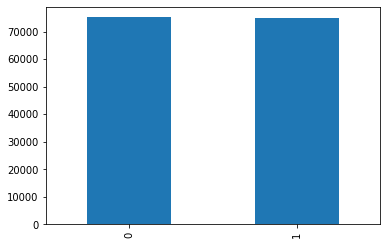

In [5]:
# train_data의 라벨 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [6]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  75173
1      1  74827


- 레이블이 비슷하지만 0인 리뷰가 근소하게 많은 것을 확인할 수 있습니다. 

## 2.2 데이터 전처리 

### 중복 데이터 

In [7]:
# 중복 데이터 확인 
print(len(set(train_data["document"])), len(set(test_data["document"])))

146183 49158


- 전체 데이터와 유니크한 데이터의 개수가 다른 것을 알 수 있습니다. 중복 데이터를 제거해 줍니다. 

In [8]:
# 중복 데이터 제거 
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print(train_data.shape)
print(test_data.shape)

(146183, 3)
(49158, 3)


- 중복 데이터가 잘 제거된 것을 확인할 수 있습니다.

###  NULL 데이터 

In [9]:
# train_data의 NULL 개수 확인
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    1
label       0
dtype: int64
id          0
document    1
label       0
dtype: int64


- NULL 데이터에 대한 처리가 필요합니다. 

In [10]:
train_data = train_data.dropna(how = 'any') 
test_data = test_data.dropna(how = 'any') 

print(train_data.shape)
print(test_data.shape)

(146182, 3)
(49157, 3)


- NULL 데이터가 잘 제거된 것을 확인할 수 있습니다.

### 문장 길이 분포 확인

In [11]:
# 텍스트데이터 문장길이의 리스트를 생성
total_data_text = list(train_data['document']) + list(test_data['document'])

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  35.947880351593895
문장길이 최대 :  146
문장길이 표준편차 :  29.521958473787635


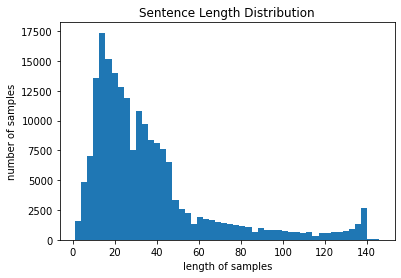

In [12]:
# 문장 길이 분포 확인
plt.hist([len(tokens) for tokens in total_data_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title("Sentence Length Distribution")
plt.show()

In [13]:
# 문장의 길이 별로 확인하는 함수
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

In [14]:
# 길이가 1인 문장 
check_sentence_with_length(total_data_text, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [15]:
# 길이가 3인 문장 
check_sentence_with_length(total_data_text, 3)

좋구나
10점
처ㅝ주
솔직히
4대강
재밌다
재밌군
좋았다
재미무
보지마
볼만함
b b
dsa
웃스!
♥♥♥
재밋네
최고다
재밌음
쓰래기
갑이다
료코짱
2빠닼
만세-
OOO
ㅋㅋㅋ
아하!
재및음
좋아여
재미쪙
대박!
에혀~
3.6
가보자
bad
신선함
와우!
즐ㄹㅋ
좋아요
아ㅅㅂ
쨩이야
굿~!
ㅉㅉㅉ
재밋다
지못미
나이스
오짱!
전형적
원주율
좋은테
2.6
굿!!
1등?
보세요
잼없다
다섯개
접어라
쓰중쓰
좋다.
음..
좋군.
싸우자
멋져.
...
직인다
짱짱짱
별로임
진리임
감동적
최고!
재밌어
걍 굿
아시바
최고~
팬이다
별로다
좋다,
잼있다
최고.
감동!
잠온다
의리!
별로~
즐..
썩었내
짱멋짐
ㄴㄹㄴ
성룡짱
꿀잼♥
쵝오!
괜찮네
막장.
억지.
김서울
철규찡
무셔움
지겨워
꼭보셈
쓰레기
그다지
훌륭함
최고임


- 짧은 데이터도 감성 분석에서 사용될 수 있으므로 최대 길이만 지정하여 적절한 문장 길이를 지정해 줍니다. 

In [16]:
# 최대 길이를 (평균 + 2.3*표준편차)로 지정한다면,  
max_tokens = np.mean(num_tokens) + 2.3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  103
전체 문장의 0.9441944516967937%가 maxlen 설정값 이내에 포함됩니다. 


In [17]:
max_len = 103

# 길이 조건에 맞는 문장만 선택
filtered_train_text = [s for s in list(train_data['document']) if len(s) <= max_len]
filtered_train_data = train_data.loc[(train_data['document'].isin(filtered_train_text))]
print(len(filtered_train_text))
print(filtered_train_data.shape)

138008
(138008, 3)


In [18]:
filtered_test_text = [s for s in list(test_data['document']) if len(s) <= max_len]
filtered_test_data = test_data.loc[(test_data['document'].isin(filtered_test_text))]
print(len(filtered_test_text))
print(filtered_test_data.shape)

46430
(46430, 3)


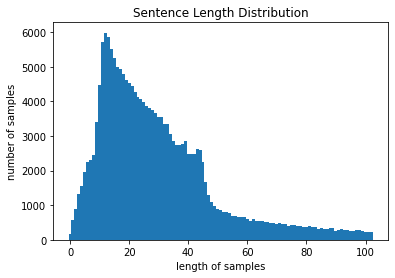

In [19]:
filtered_corpus = filtered_train_text + filtered_test_text

# 분포도 다시 그려보기
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 최종적인 데이터 분포를 확인해 보았습니다.

# 3. SentencePiece 모델 학습

sentence piece 모델에서 unigram model을 학습시켜 봅니다. 

In [20]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/GoingDeeper/nlp2/data/nmsc_spm.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus 활용
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train( # unigram model 
    '--input={} --model_prefix=nmsc_spm_unigram --vocab_size={}'.format(temp_file, vocab_size)    
) 

- spm.SentencePieceTrainer.Train() :      
    https://github.com/google/sentencepiece/tree/master/python#model-training     
    parameter :    
    - --input: one-sentence-per-line raw corpus file    
    - --model_prefix: output model name prefix
    - --vocab_size: vocabulary size    
    - --model_type: model type. Choose from unigram (default), bpe, char, or word     
    https://github.com/google/sentencepiece#train-sentencepiece-model

In [21]:
!ls -l nmsc_spm_unigram*

-rw-r--r-- 1 root root 375008 Dec 20 00:49 nmsc_spm_unigram.model
-rw-r--r-- 1 root root 144447 Dec 20 00:49 nmsc_spm_unigram.vocab


- 정상적으로 SentencePiece 모델 학습이 완료된 후 nmsc_spm_unigram.model 파일과 nmsc_spm_unigram.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.
      
그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [22]:
s = spm.SentencePieceProcessor()
s.Load('nmsc_spm_unigram.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1488, 9, 396, 15, 1334, 9, 137, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# 4.  Tokenizer 함수 작성


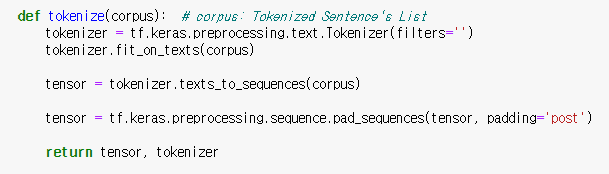
    
우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { \<word> : \<idx> } 형태를 가지는 word_index 사전과 { \<idx> : \<word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding 처리를 해줍니다. 

In [23]:
def sp_tokenize(s, corpus):
    # s : SentencePieceProcessor
    # corpus : sentence's List  # 1

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./nmsc_spm_unigram.vocab", 'r') as f:
        vocab = f.readlines()
    
    # 2
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})
    
    # 3
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

- f.readlines() : ead all the lines of a file in a list    
    https://docs.python.org/3/tutorial/inputoutput.html#methods-of-file-objects
- dict.update() : Update the dictionary with the key/value pairs, overwriting existing keys    
    https://docs.python.org/3/library/stdtypes.html#dict.update
- tf.keras.preprocessing.sequence.pad_sequences() : Pads sequences to the same length     
    https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [24]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 556 3349   14 1390 2288    4    0    0    0    0]
 [1592 2304  258  586    9    3   17 7938  599    8]]


## SentencePiece 토크나이저로 토큰화

In [25]:
print(filtered_train_data.shape, filtered_test_data.shape)

(138008, 3) (46430, 3)


In [27]:
print(len(filtered_corpus)) # filtered_train_text + filtered_test_text

184438


In [28]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

In [30]:
# X_train, y_train, X_test, y_test 만들기 
X_train, y_train = tensor[:138008], np.array(list(filtered_train_data['label']))
X_test, y_test = tensor[138008:], np.array(list(filtered_test_data['label']))

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

138008 46430
138008 46430


In [31]:
print(X_train.shape)
print(X_test.shape)

(138008, 79)
(46430, 79)


- train, test 데이터의 tensor가 잘 만들어진 것을 알 수 있다. 

# 5. 딥러닝 모델 설계와 훈련 및 validation set 구성

## validation set 구성

Validation set(검정 데이터)은 training set으로 만들어진 모델의 성능을 측정하기 위해 사용된다. 일반적으로 어떤 모델이 가장 데이터에 적합한지 찾아내기 위해서 다양한 파라미터와 모델을 사용해보게 되며, 그 중 validation set으로 가장 성능이 좋았던 모델을 선택한다.
- 참고 : https://modern-manual.tistory.com/19

In [32]:
# train set 100000건 분리
partial_x_train = X_train[:100000]  
partial_y_train = y_train[:100000]

# train set을 제외한 나머지 validation set
x_val = X_train[100000:]   
y_val = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(100000, 79)
(100000,)
(38008, 79)
(38008,)


## RNN 모델

텍스트 데이터를 다루는 데 주로 사용되는 딥러닝 모델은 바로 Recurrent Neural Network(RNN)입니다. RNN은 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델로 알려져 있습니다.

In [33]:
vocab_size = 8000    # 어휘 사전의 크기 (8000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 설계 
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 8로 
rnn_model.add(keras.layers.Dense(8, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 257,393
Trainable params: 257,393
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 모델 학습 
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보기

rnn_history = rnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 7s 22ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 2/20
196/196 [==============================] - 4s 18ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 3/20
196/196 [==============================] - 4s 19ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 4/20
196/196 [==============================] - 4s 19ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 5/20
196/196 [==============================] - 4s 19ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 6/20
196/196 [==============================] - 4s 19ms/step - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 7/20
196/196 [==============================] - 4s 19ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5014

In [35]:
# train/validation loss, accuracy 확인
rnn_history_dict = rnn_history.history
print(rnn_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [36]:
rnn_acc = rnn_history_dict['accuracy']
rnn_val_acc = rnn_history_dict['val_accuracy']
rnn_loss = rnn_history_dict['loss']
rnn_val_loss = rnn_history_dict['val_loss']

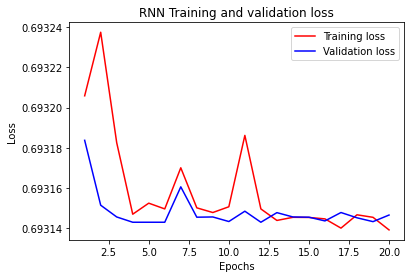

In [37]:
## Training loss & Validation loss 그래프 
epochs = range(1, len(rnn_acc) + 1)

# r는 "빨간 실선"
plt.plot(epochs, rnn_loss, 'r', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, rnn_val_loss, 'b', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

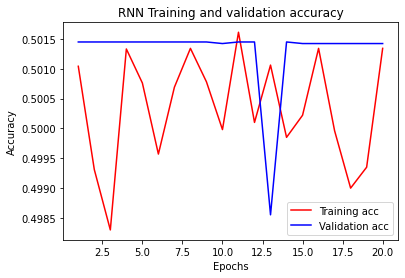

In [38]:
## Training accuracy & validation accuracy 그래프

plt.clf()   # 그림 초기화

plt.plot(epochs, rnn_acc, 'r', label='Training acc')
plt.plot(epochs, rnn_val_acc, 'b', label='Validation acc')
plt.title('RNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [39]:
# 모델 평가 
rnn_results = rnn_model.evaluate(X_test,  y_test, verbose=2)

print(rnn_results)

1451/1451 - 7s - loss: 0.6931 - accuracy: 0.5059
[0.6931450366973877, 0.5059229135513306]


- 일반적으로 성능 좋은 RNN 모델이 여기서 50.6% 의 test accuracy를 달성한 것을 볼 수 있다. 

## 1-D CNN 모델

텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용할 수도 있습니다.
    
1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됩니다. 이 방식도 텍스트를 처리하는 데 RNN 못지않은 효율을 보여줍니다.    

그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점이 있습니다.

In [40]:
vocab_size = 8000    # 어휘 사전의 크기 (8000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 설계
cnn1d_model = keras.Sequential()
cnn1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn1d_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(keras.layers.MaxPooling1D(5))
cnn1d_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(keras.layers.GlobalMaxPooling1D())
cnn1d_model.add(keras.layers.Dense(8, activation='relu'))
cnn1d_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 

cnn1d_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          3600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [41]:
# 모델 학습
cnn1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 보기

cnn1d_history = cnn1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
196/196 [==============================] - 10s 31ms/step - loss: 0.6243 - accuracy: 0.6214 - val_loss: 0.3587 - val_accuracy: 0.8442
Epoch 2/20
196/196 [==============================] - 2s 13ms/step - loss: 0.3140 - accuracy: 0.8678 - val_loss: 0.3415 - val_accuracy: 0.8509
Epoch 3/20
196/196 [==============================] - 3s 13ms/step - loss: 0.2676 - accuracy: 0.8905 - val_loss: 0.3429 - val_accuracy: 0.8511
Epoch 4/20
196/196 [==============================] - 3s 13ms/step - loss: 0.2307 - accuracy: 0.9122 - val_loss: 0.3587 - val_accuracy: 0.8488
Epoch 5/20
196/196 [==============================] - 3s 13ms/step - loss: 0.1826 - accuracy: 0.9354 - val_loss: 0.4011 - val_accuracy: 0.8426
Epoch 6/20
196/196 [==============================] - 3s 13ms/step - loss: 0.1234 - accuracy: 0.9629 - val_loss: 0.4681 - val_accuracy: 0.8359
Epoch 7/20
196/196 [==============================] - 3s 13ms/step - loss: 0.0768 - accuracy: 0.9802 - val_loss: 0.5600 - val_accuracy: 0.831

In [42]:
# train/validation loss, accuracy 확인
cnn1d_history_dict = cnn1d_history.history
print(cnn1d_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [43]:
cnn1d_acc = cnn1d_history_dict['accuracy']
cnn1d_val_acc = cnn1d_history_dict['val_accuracy']
cnn1d_loss = cnn1d_history_dict['loss']
cnn1d_val_loss = cnn1d_history_dict['val_loss']

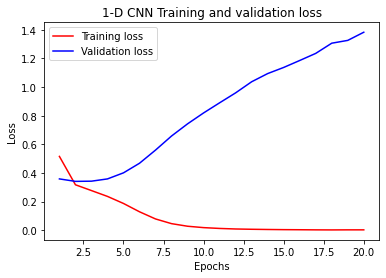

In [44]:
## Training loss & Validation loss 그래프 
epochs = range(1, len(cnn1d_acc) + 1)

# r는 "빨간 실선"
plt.plot(epochs, cnn1d_loss, 'r', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, cnn1d_val_loss, 'b', label='Validation loss')
plt.title('1-D CNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

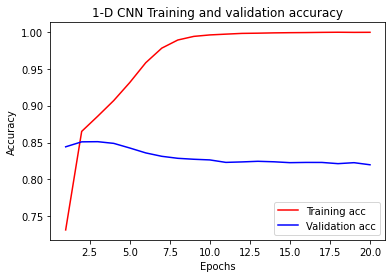

In [45]:
## Training accuracy & validation accuracy 그래프

plt.clf()   # 그림 초기화

plt.plot(epochs, cnn1d_acc, 'r', label='Training acc')
plt.plot(epochs, cnn1d_val_acc, 'b', label='Validation acc')
plt.title('1-D CNN Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
# 모델 평가
cnn1d_results = cnn1d_model.evaluate(X_test,  y_test, verbose=2)

print(cnn1d_results)

1451/1451 - 5s - loss: 1.4185 - accuracy: 0.8183
[1.418500304222107, 0.818307101726532]


- test accuracy 81.8% 달성한 것을 볼 수 있다. 